In [734]:
%matplotlib notebook

import numpy as np
import math
import time
import scipy.stats as sta
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

import winsound
import pickle

W = 60    # Time frame window: 60 frames (= 2 seconds)


In [15]:
# Retrieve data from the given file to separate lists
def get_data(filename):
    global frame_num_count, frame_num
    global x, y, z, velocity, intensity
    
    # Open file
    with open(filename, "r") as f:
        lines = f.readlines()

    wordlist = []
    for line in lines:
        for word in line.split():
            wordlist.append(word)

    for i in range(0, len(wordlist)):
        if wordlist[i] == "point_id:" and wordlist[i+1] == "0":
            frame_num_count += 1
        if wordlist[i] == "point_id:":
            frame_num.append(frame_num_count)
        if wordlist[i] == "x:":
            x.append(wordlist[i+1])
        if wordlist[i] == "y:":
            y.append(wordlist[i+1])
        if wordlist[i] == "z:":
            z.append(wordlist[i+1])
        if wordlist[i] == "velocity:":
            velocity.append(wordlist[i+1])
        if wordlist[i] == "intensity:":
            intensity.append(wordlist[i+1])

    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    frame_num = np.asarray(frame_num)
    velocity = np.asarray(velocity)
    intensity = np.asarray(intensity)

    x = x.astype(np.float)
    y = y.astype(np.float)
    z = z.astype(np.float)
    velocity = velocity.astype(np.float)
    intensity = intensity.astype(np.float)
    frame_num = frame_num.astype(np.int)



In [5]:
# Organize data in multiple lists to a list "final"
def organized_data():
    data = dict()
    final = np.zeros([len(frame_num), 6])
    
    for i in range(len(frame_num)):
        if int(frame_num[i]) in data:
            data[frame_num[i]].append([x[i], y[i], z[i], velocity[i], intensity[i]])
        else:
            data[frame_num[i]] = []
            data[frame_num[i]].append([x[i], y[i], z[i], velocity[i], intensity[i]])

        final[i, 0] = int(frame_num[i])
        final[i, 1] = x[i]
        final[i, 2] = y[i]
        final[i, 3] = z[i]
        final[i, 4] = velocity[i]
        final[i, 5] = intensity[i]

    return data, final


In [6]:
# Define the function to fit distribution in Z dimension
def Gaussian2(x, *par):
    return par[0]*np.exp(-np.power(x-par[2], 2) / (2 * np.power(par[4], 2))) + par[1]*np.exp(-np.power(x-par[3], 2) / (2 * np.power(par[5], 2)))


In [7]:
# To find x_min, x_max
def find_x_bounds(x_data, pillar = 32, debug = False):
    kwargs = {'color': 'b'}
    if debug:
        plt.figure()
        ver, hor, patch = plt.hist(x_data, bins = pillar, density = True, **kwargs)
    else:
        ver, hor = np.histogram(x_data, bins = pillar, density = True)
    mean = np.mean(x_data)
    std = np.std(x_data)
    fit = sta.norm.pdf(hor, mean, std)
    fwhm1 = (max(fit)+fit[0])/2
    fwhm2 = (max(fit)+fit[-1])/2

    x_min = min(x_data)
    x_max = max(x_data)
    for i in range(len(fit)-1):
        if fit[i] < fwhm1 <= fit[i+1]:
            x_min = hor[i+1]
        elif fit[i] >= fwhm2 > fit[i+1]:
            x_max = hor[i]

    if debug:
        kwargs = {'color': 'orange'}
        plt.plot(hor, fit, **kwargs)
        plt.xlabel("X")
        plt.axvline(x=x_min, **kwargs)
        plt.axvline(x=x_max, **kwargs)
        print("x_min=" + str(x_min) + "\tx_max=" + str(x_max))

    return x_min, x_max


In [8]:
# To find y_min, y_max
def find_y_bounds(y_data, pillar = 32, debug = False):
    kwargs = {'color': 'b'}
    if debug:
        plt.figure()
        ver, hor, patch = plt.hist(y_data, bins = pillar, density = True, **kwargs)
    else:
        ver, hor = np.histogram(y_data, bins = pillar, density = True)
    mean = np.mean(y_data)
    std = np.std(y_data)

    y_min = min(y_data)
    y_max = max(y_data)
    y_min = max(y_min, mean-3*std)
    y_max = min(y_max, mean+3*std)

    if debug:
        kwargs = {'color': 'orange'}
        fit = sta.norm.pdf(hor, mean, std)
        plt.plot(hor, fit, **kwargs)
        plt.xlabel("Y")
        plt.axvline(x=y_min, **kwargs)
        plt.axvline(x=y_max, **kwargs)
        print("y_min=" + str(y_min) + "\ty_max=" + str(y_max))

    return y_min, y_max


In [9]:
# To find z_min, z_max
def find_z_bounds(z_data, pillar = 32, debug = False, cov0 = 0.3):
    kwargs = {'color': 'b'}
    if debug:
        plt.figure()
        ver, hor, patch = plt.hist(z_data, bins = pillar, density = True, **kwargs)
    else:
        ver, hor = np.histogram(z_data, bins = pillar, density = True)
    fit, cov = curve_fit(Gaussian2, hor[:-1], ver, p0=[1,1,0,1,cov0,cov0])

    z_min = min(z_data)
    z_max = max(z_data)
    z_min = max(z_min, fit[2]-3*fit[4])
    z_max = min(z_max, fit[2]+3*fit[4])  # Gap between two Gaussians

    if debug:
        kwargs = {'color': 'orange'}
        plt.plot(hor, Gaussian2(hor, *fit), **kwargs)
        plt.xlabel("Z")
        plt.axvline(x=z_min, **kwargs)
        plt.axvline(x=z_max, **kwargs)
        print("z_min=" + str(z_min) + "\tz_max=" + str(z_max))
        print(fit[2], fit[4])

    return z_min, z_max


In [10]:
# TODO: Not tested yet, for future work
def train_z_cov(z_data, pillar = 32, cov0 = 0.3, step = 0.02):
    z_min = 0
    z_max = 0
    cov = cov0
    while z_min == 0 and z_max == 0:
        try:
            z_min, z_max = find_z_bounds(z_data, pillar = pillar, cov0 = cov)
        except:
            cov += step
    return z_min, z_max


In [662]:
# To filter out noises
def sort_data(startFrame, endFrame, clean = True):
    i_prev = 0
    for i in range(len(frame_num)):
        if frame_num[i] == startFrame - 1:
            i_prev = i
            continue
        if frame_num[i] == endFrame:
            i_curr = i
            break

    print("time=%.2f"+str(startFrame/30)+"s\tstartFrame="+str(startFrame)+"\tendFrame="+str(endFrame)+"\ti_prev="+str(i_prev)+"\ti_curr="+str(i_curr))

    # Gaussian fit, similar to the method of voxels
    pillar = 32
    x_min, x_max = find_x_bounds(x[i_prev:i_curr], pillar)
    y_min, y_max = find_y_bounds(y[i_prev:i_curr], pillar)
    
    # z: curve_fit may not converge -> use iterative train_z_cov
    try:
        z_min, z_max = find_z_bounds(z[i_prev:i_curr], pillar)
    except:
        z_min, z_max = find_x_bounds(z[i_prev:i_curr], pillar)

    # print(x_min, x_max, y_min, y_max, z_min, z_max)

    i_list = []
    for i in range(i_prev, i_curr):
        if clean:
            if x_min <= x[i] <= x_max and z_min <= z[i] <= z_max:
                i_list.append(i)
        else:
            i_list.append(i)

    # print("i_list = " + str(i_list))
    return i_list


In [661]:
# Sorting order matters, x based on sorted z, y based on sorted x and z (z -> x -> y, because z most effective according to the preprocess, x being the next, y the least)
# Drawbacks: two more loops, calculation heavier (0.2s more)
def sort_data2(startFrame, endFrame, clean = True):
    i_prev = 0
    for i in range(len(frame_num)):
        if frame_num[i] == startFrame - 1:
            i_prev = i
            continue
        if frame_num[i] == endFrame:
            i_curr = i
            break

    print("time="+str(startFrame/30)+"s\tstartFrame="+str(startFrame)+"\tendFrame="+str(endFrame)+"\ti_prev="+str(i_prev)+"\ti_curr="+str(i_curr))

    # Gaussian fit, similar to the method of voxels
    pillar = 32

    # For z_min, z_max
    # z: curve_fit may not converge -> use iterative train_z_cov
    try:
        z_min, z_max = find_z_bounds(z[i_prev:i_curr], pillar)
    except:
        z_min, z_max = find_x_bounds(z[i_prev:i_curr], pillar)

    # For x_min, x_max
    i_list_x = []
    for i in range(i_prev, i_curr):
        if z_min <= z[i] <= z_max:
            i_list_x.append(i)
    if i_list_x == []:
        return []
    else:
        x_min, x_max = find_x_bounds(x[i_list_x], pillar)

    # For y_min, y_max
    i_list_y = []
    for i in i_list_x:
        if x_min <= x[i] <= x_max:
            i_list_y.append(i)
    if i_list_y == []:
        return []
    else:
        y_min, y_max = find_y_bounds(y[i_list_y], pillar)

    # print(x_min, x_max, y_min, y_max, z_min, z_max)

    i_list = []
    
    if clean:
        for i in i_list_y:
            if y_min <= y[i] <= y_max:
                i_list.append(i)
    else:
        for i in range(i_prev, i_curr):
            i_list.append(i)

    # print("i_list = " + str(i_list))
    return i_list


In [752]:
# Use graph community (fast greedy) to denoise (locate signal from noise)
# Slow when running, about 3 min for each 60-frame window
def sort_data_graph(startFrame, endFrame, final, threshold = 0.2):
    i_prev = 0
    for i in range(len(frame_num)):
        if frame_num[i] == startFrame - 1:
            i_prev = i
            continue
        if frame_num[i] == endFrame:
            i_curr = i
            break
    i_count = i_curr - i_prev
    
    print("time="+str(startFrame/30)+"s\tstartFrame="+str(startFrame)+"\tendFrame="+str(endFrame)+"\ti_prev="+str(i_prev)+"\ti_curr="+str(i_curr))
    
    # Adjacency matrix
    A = np.zeros((i_count, i_count))
    for i in range(i_count):
        for j in range(i, i_count):
            dist = np.linalg.norm(final[np.array(range(i_prev, i_curr))[i]][1:4] - final[np.array(range(i_prev, i_curr))[j]][1:4])
            if dist > threshold or dist == 0:
                A[i, j] = 0
                A[j, i] = 0
            else:
                A[i, j] = 1
                A[j, i] = 1
    
    # Build graph from adjacency matrix
    G = nx.from_numpy_matrix(A)
    # Find community
    G_community = greedy_modularity_communities(G)
    # Translate graph index to frame_num index
    i_list_graph = []
    for each in G_community:
        i_list_graph.append(np.array(range(i_prev, i_curr))[list(each)])
    
    # Find which one of the graph clusters represent human figure: max sum abs velocity
    score_list = []
    for cluster in i_list_graph:
        score = 0
        for point in cluster:
            score += abs(final[point, 4])
        score_list.append(score)

    if score_list[np.argmax(score_list)] > 0:
        return i_list_graph[np.argmax(score_list)]
    else:
        return []


In [13]:
# Shift and add
# Problem: if sorted data not clean enough, max velocity point may fall in noises, making the shifted data a mess -> Solution: use sort_data2 func, a lot cleaner
# Problem: data too sparse for 1 frame, may or may not have large distance change in 60 frames -> Solution: shift and add every 10 frame (?)
def shift_data(i_list):
    center = expect(i_list)

    final2 = np.zeros([len(frame_num), 6])

    # data2: To store frame_index with same frame_number in a dict
    data2 = dict()
    for i in i_list:
        if int(frame_num[i]) in data2:
            data2[frame_num[i]].append(i)
        else:
            data2[frame_num[i]] = []
            data2[frame_num[i]].append(i)

    # TODO: use the expected point as a reference, instead of the max_velocity point
    # Shift each frame so that all velocity_max points for each frame in the same position as center of every 60 frames
    for each_frame in data2:
        vel_max_frame_index = data2[each_frame][np.argmax(velocity[data2[each_frame]])]
        for i in data2[each_frame]:
            final2[i, 0] = int(frame_num[i])
            final2[i, 1] = x[i] - (x[vel_max_frame_index] - center[0])
            final2[i, 2] = y[i] - (y[vel_max_frame_index] - center[1])
            final2[i, 3] = z[i] - (z[vel_max_frame_index] - center[2])
            final2[i, 4] = velocity[i]
            final2[i, 5] = intensity[i]

    return final2


In [14]:
def normalize(x, x_min, x_max):
    return (x-x_min)/(x_max-x_min)


In [16]:
# Estimate the center position of the figure
# "index" choices:
# = 1: max velocity
# = 2: max intensity
# = 3: combined max velocity and intensity
# = 4: velocity-weighted
# = 5: intensity-weighted
# = 6: combined velocity & intensity-weighted
# = 7: average of all position
def expect(i_list, index = 5, vel_weight = 0.5):

    # Use the point with max velocity/intensity as the estimated center
    if index in [1, 2]:
        i_max = i_list[np.argmax(np.abs(final[i_list, index + 3]))]
        x = x[i_max]
        y = y[i_max]
        z = z[i_max]
        return [x, y, z]

    # Use max combined velocity/intensity
    if index == 3:
        i_max = i_list[np.argmax(np.abs(final[i_list, 4]) * vel_weight + np.abs(final[i_list, 5]) * (1 - vel_weight))]
        x = x[i_max]
        y = y[i_max]
        z = z[i_max]
        return [x, y, z]

    if index == 7:
        x = np.average(final[i_list, 1])
        y = np.average(final[i_list, 2])
        z = np.average(final[i_list, 3])
        return [x, y, z]

    # Use the velocity(/intensity)-weighted expected position as the estimated center
    if index in [4, 5]:
        weight = np.abs(final[i_list, index])
    elif index == 6:
        weight = np.abs(final[i_list, 4]) * vel_weight + np.abs(final[i_list, 5]) * (1 - vel_weight)

    if np.sum(weight) != 0:
        x = np.dot(final[i_list, 1], weight)/np.sum(weight)
        y = np.dot(final[i_list, 2], weight)/np.sum(weight)
        z = np.dot(final[i_list, 3], weight)/np.sum(weight)
    else:
        x = np.average(final[i_list, 1])
        y = np.average(final[i_list, 2])
        z = np.average(final[i_list, 3])
    return [x, y, z]


In [17]:
def find_verts(i_list, datalist):
    x_min = min(datalist[i_list, 1])
    x_max = max(datalist[i_list, 1])
    y_min = min(datalist[i_list, 2])
    y_max = max(datalist[i_list, 2])
    z_min = min(datalist[i_list, 3])
    z_max = max(datalist[i_list, 3])
    # velocity_min = min(datalist[i_list, 4])
    # velocity_max = max(datalist[i_list, 4])
    # intensity_min = min(datalist[i_list, 5])
    # intensity_max = max(datalist[i_list, 5])

    center = expect(i_list)

    verts = [x_min, x_max, y_min, y_max, z_min, z_max, center]

    return verts


In [206]:
def plot_data(ax, i_list, datalist, color = 'k', index = 5):
    # index = 4: use "velocity" for alpha; = 5: use "intensity" for alpha
    weight_min = min(np.abs(datalist[i_list, index]))
    weight_max = max(np.abs(datalist[i_list, index]))

    for i in i_list:
        if index in [4, 5]:
            alpha = normalize(abs(datalist[i, index]), weight_min, weight_max)
        else:
            alpha = 1
        ax.scatter(datalist[i, 1], datalist[i, 2], datalist[i, 3], color = color, alpha = alpha, marker = '.')


In [374]:
def plot_cube(ax, verts, alpha = 1, color = 'r', plot_center = False):
    x_min, x_max, y_min, y_max, z_min, z_max, center = verts

    xx = [x_min, x_min, x_max, x_max, x_min]
    yy = [y_min, y_max, y_max, y_min, y_min]
    kwargs = {'alpha': alpha, 'color': color}
    ax.plot3D(xx, yy, [z_min]*5, **kwargs)
    ax.plot3D(xx, yy, [z_max]*5, **kwargs)
    ax.plot3D([x_min, x_min], [y_min, y_min], [z_min, z_max], **kwargs)
    ax.plot3D([x_min, x_min], [y_max, y_max], [z_min, z_max], **kwargs)
    ax.plot3D([x_max, x_max], [y_min, y_min], [z_min, z_max], **kwargs)
    ax.plot3D([x_max, x_max], [y_max, y_max], [z_min, z_max], **kwargs)

    # Plot the center point of the figure
    if plot_center:
        ax.scatter(center[0], center[1], center[2], color = 'r')


In [20]:
def plot_traj(ax, count):
    traj = []
    for i in range(0, count):
        i_list = sort_data2(i*W, (i+1)*W)
        if i_list != []:
            # final2 = shift_data(i_list)
            # plot_data(ax, i_list, final2)
            # verts = find_verts(i_list, final2)
            # plot_cube(ax, verts)
            traj.append(expect(i_list))
            del i_list

    traj = np.array(traj)
    ax.plot3D(traj[:, 0], traj[:, 1], traj[:, 2], color = 'b')
    print("effective rate", len(traj), count, len(traj)/count)
    # print(traj)

    # Plot range of the traj
    x_min = min(traj[:, 0])
    x_max = max(traj[:, 0])
    y_min = min(traj[:, 1])
    y_max = max(traj[:, 1])
    z_min = min(traj[:, 2])
    z_max = max(traj[:, 2])
    verts = [x_min, x_max, y_min, y_max, z_min, z_max, 0]
    print(verts[:-1])
    plot_cube(ax, verts, 0.5)


In [21]:
# Average figure size among all frames
def figure_size():
    dis_x = []
    dis_y = []
    dis_z = []

    for i in range(0, int(frame_num_count/W)):
        i_list = sort_data2(i*W, (i+1)*W)
        if len(i_list) > 1:
            final2 = shift_data(i_list)
            verts = find_verts(i_list, final2)
            # x_min, x_max, y_min, y_max, z_min, z_max, center = verts
            dis_x.append(verts[1]-verts[0])
            dis_y.append(verts[3]-verts[2])
            dis_z.append(verts[5]-verts[4])
            del i_list

    # TODO (need debug): why for jump (/etc) data, x(/y/z)_min=0
    print("x_min=" + str(min(dis_x)) + "m\tx_max=" + str(max(dis_x)) + "m\tx_ave=" + str(np.average(dis_x)) + "m")
    print("y_min=" + str(min(dis_y)) + "m\ty_max=" + str(max(dis_y)) + "m\ty_ave=" + str(np.average(dis_y)) + "m")
    print("z_min=" + str(min(dis_z)) + "m\tz_max=" + str(max(dis_z)) + "m\tz_ave=" + str(np.average(dis_z)) + "m")


In [22]:
# Simply use the figure height and perfect/average human body model
# Reference: http://humanproportions.com/
def plot_skeleton(ax, i_list, datalist, color = 'm'):
    x_min, x_max, y_min, y_max, z_min, z_max, center = verts
    x0, y0, z0 = center[:]

    body = []

    # TODO: 
    # if y_max - y_min >= x_max - x_min:
    #     # Posture in y-orientation
    # else:
    #     # Posture in x-orientation
    # (default in y-orientation for now)

    h = z_max - z_min
    body.append([x0, y0, h/2])                          # 0: spine base
    body.append([x0, y0, h*(7/8-1/24)])                 # 1: spine shoulder
    body.append([x0, y0, h*7/8])                        # 2: neck
    body.append([x0, y0, h-h/16])                       # 3: head
    body.append([x0, y0-h/8, body[1][2]])               # 4: left shoulder
    body.append([x0, body[4][1], body[1][2]-1.7*h/8])   # 5: left elbow
    body.append([x0, body[4][1], body[5][2]-1.8*h/8])   # 6: left hand
    body.append([x0, 2*y0-body[4][1], body[4][2]])      # 7: right shoulder
    body.append([x0, body[7][1], body[5][2]])           # 8: right elbow
    body.append([x0, body[7][1], body[6][2]])           # 9: right hand
    body.append([x0, y0-0.1*h, h/2])                    # 10: left hip
    body.append([x0, body[10][1], h/4])                 # 11: left knee
    body.append([x0, body[10][1], 0])                   # 12: left foot
    body.append([x0, 2*y0-body[10][1], body[10][2]])    # 13: right hip
    body.append([x0, body[13][1], body[11][2]])         # 14: right knee
    body.append([x0, body[13][1], body[12][2]])         # 15: right foot

    body = np.array(body)
    body = body + np.array([0, 0, z_min])

    # For plot reference
    # ax.plot3D([x1, x2], [y1, y2], [z1, z2], 'b')
    kwargs = {'color': color, 'marker': '.'}
    ax.plot3D(body[0:4,0], body[0:4,1], body[0:4,2], **kwargs)
    connects = []
    connects.append([1, 4, 5, 6])
    connects.append([1, 7, 8, 9])
    connects.append([0, 10, 11, 12])
    connects.append([0, 13, 14, 15])
    for connect in connects:
        ax.plot3D(body[connect,0], body[connect,1], body[connect,2], **kwargs)
    tips = [3, 6, 9, 12, 15]
    ax.scatter(body[tips,0], body[tips,1], body[tips,2], color = color, marker = 'o')
    plt.axis("square")


In [23]:
# TODO: Below are the second method to estimate figure posture/skeleton, need improvement
# To estimate torso body part
# Intensity-based weighted lower and upper bounds estimation
def find_torso(i_list, datalist):
    center = expect(i_list)

    # Initialize
    x_min = 0
    x_max = 0
    y_min = 0
    y_max = 0
    z_min = 0
    z_max = 0

    weight_min = 0
    weight_max = 0
    index = 5       # index = 4: use "velocity" as weight; = 5: use "intensity" as weight

    for i in i_list:
        if datalist[i, 1] <= center[0]:
            x_min += datalist[i, 1] * abs(datalist[i, index])
            weight_min += abs(datalist[i, index])
        else:
            x_max += datalist[i, 1] * abs(datalist[i, index])
            weight_max += abs(datalist[i, index])
    x_min = x_min/weight_min
    x_max = x_max/weight_max

    weight_min = 0
    weight_max = 0
    for i in i_list:
        if datalist[i, 2] <= center[1]:
            y_min += datalist[i, 2] * abs(datalist[i, index])
            weight_min += abs(datalist[i, index])
        else:
            y_max += datalist[i, 2] * abs(datalist[i, index])
            weight_max += abs(datalist[i, index])
    y_min = y_min/weight_min
    y_max = y_max/weight_max

    weight_min = 0
    weight_max = 0
    for i in i_list:
        if datalist[i, 3] <= center[2]:
            z_min += datalist[i, 3] * abs(datalist[i, index])
            weight_min += abs(datalist[i, index])
        else:
            z_max += datalist[i, 3] * abs(datalist[i, index])
            weight_max += abs(datalist[i, index])
    z_min = z_min/weight_min
    z_max = z_max/weight_max

    verts = [x_min, x_max, y_min, y_max, z_min, z_max, center]

    return verts


In [24]:
# Use velocity for limbs estimation
def find_limbs(i_list, datalist, torso_verts):
    limbs = []

    argsort = np.argsort(datalist[i_list,:], axis = 0)
    z_min1 = argsort[0][3]  # foot 1
    z_min2 = argsort[1][3]  # foot 2
    z_max = argsort[-1][3]  # head
    y_min = argsort[0][2]   # hand 1
    y_max = argsort[-1][2]  # hand 2

    # Find tips
    limbs.append(i_list[z_max])         # 0: head
    if datalist[i_list[z_min1],2] <= datalist[i_list[z_min2],2]: # smaller y = left
        limbs.append(i_list[z_min1])    # 1: left foot
        limbs.append(i_list[z_min2])    # 2: right foot
    else:
        limbs.append(i_list[z_min2])    # 1: left foot
        limbs.append(i_list[z_min1])    # 2: right foot
    limbs.append(i_list[y_min])         # 3: left hand
    limbs.append(i_list[y_max])         # 4: right hand

    # Find joints
    y_small = []    # point_y <= center_y
    y_big = []      # point_y > center_y
    z_small = []    # point_z <= center_z
    for i in i_list:
        if datalist[i][2] <= torso_verts[2]:
            y_small.append(i)
        elif datalist[i][2] >= torso_verts[3]:
            y_big.append(i)
        if datalist[i][3] <= torso_verts[4]:
            z_small.append(i)
    # TODO: deal with situation when y_small, y_big, z_small == []

    argsort = np.argsort(datalist[y_small,:], axis = 0)
    y_elbow1 = argsort[int(len(y_small)/2)][2]
    argsort = np.argsort(datalist[y_big,:], axis = 0)
    y_elbow2 = argsort[int(len(y_big)/2)][2]
    argsort = np.argsort(datalist[z_small,:], axis = 0)
    z_knee1 = argsort[int(len(z_small)/2)][3]
    z_knee2 = argsort[int(len(z_small)/2)+1][3]

    if datalist[z_small[z_knee1],2] <= datalist[z_small[z_knee2],2]: # smaller y = left
        limbs.append(z_small[z_knee1])  # 5: left knee
        limbs.append(z_small[z_knee2])  # 6: right knee
    else:
        limbs.append(z_small[z_knee2])  # 5: left knee
        limbs.append(z_small[z_knee1])  # 6: right knee
    limbs.append(y_small[y_elbow1])     # 7: left elbow
    limbs.append(y_big[y_elbow2])       # 8: right elbow

    return limbs


In [25]:
# Plot torso and limbs
# Result: not good, easily affected by remainder noise
def plot_skeleton2(ax, i_list, datalist, color = 'm'):
    kwargs = {'color': color, 'marker': '.'}

    torso_verts = find_torso(i_list, datalist)
    x_min, x_max, y_min, y_max, z_min, z_max, center = torso_verts
    plot_cube(ax, torso_verts, color = color)
    
    limbs = find_limbs(i_list, datalist, torso_verts)

    body = []
    body = datalist[limbs,1:4]
    body = list(body)
    body.append([(x_min+x_max)/2, (y_min+y_max)/2, z_max])  # 9: spine shoulder
    body.append([(x_min+x_max)/2, y_min, z_max])    # 10: left shoulder
    body.append([(x_min+x_max)/2, y_max, z_max]) # 11: right shoulder
    body.append([(x_min+x_max)/2, y_min, z_min]) # 12: left hip
    body.append([(x_min+x_max)/2, y_max, z_min]) # 13: right hip
    body = np.array(body)
    # ax.scatter(body[:,0], body[:,1], body[:,2],color='b',alpha=1)

    connects = []
    connects.append([0,9])
    connects.append([3,7,10])
    connects.append([4,8,11])
    connects.append([1,5,12])
    connects.append([2,6,13])

    for connect in connects:
        ax.plot3D(body[connect,0], body[connect,1], body[connect,2], **kwargs)
    ax.scatter(body[:5,0], body[:5,1], body[:5,2], color = color, marker = 'o')
    # for limb in limbs:
        # ax.scatter(datalist[limb,1],datalist[limb,2],datalist[limb,3], color='b')
        # ax.plot3D([center[0],datalist[limb,1]],[center[1],datalist[limb,2]],[center[2],datalist[limb,3]], color='b')
    plt.axis("square")


In [442]:
# Use graph (similar to sort_data_graph) to find human figure's body part
# Result not good, threshold difficult to set
# Even if dynamically search for a threshold to limit cluster num, result not good
# TODO: need improve
def find_figure_cluster(i_list, final, threshold = 0.07):
    point_count = len(i_list)

    # Adjacency matrix
    A = np.zeros((point_count, point_count))
    for i in range(point_count):
        for j in range(i, point_count):
            dist = np.linalg.norm(final[i_list[i]][1:4] - final[i_list[j]][1:4])
            if dist > threshold or dist == 0:
                A[i, j] = 0
                A[j, i] = 0
            else:
                A[i, j] = 1
                A[j, i] = 1
    
    # Build graph from adjacency matrix
    G = nx.from_numpy_matrix(A)
    # Find community
    G_community = greedy_modularity_communities(G)

    # Translate graph index to frame_num index
    figure_part = []
    for each in G_community:
        if len(list(each)) > 2:
            figure_part.append(i_list[list(each)])

    return figure_part
    

In [556]:
# Plot settings, same for all plots
def ax_settings(ax):
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
#     ax.set_xlim(-1, 5)
#     ax.set_ylim(-1, 2)
#     ax.set_zlim(-0.5, 1.5)


## Main

In [753]:
# Main
# filename = "./data/sample_walk_1_180frame.txt"
# filename = "./data/sample_walk_1.txt"
filename = "./data/Train/jump/__jump_122s.txt"
# filename = "./data/Train/walk/___walk_191s.txt"
# filename = "./data/Train/squats/___squats_186s.txt"
# filename = "./data/Train/jump/___jump_180s.txt"
# filename = "./data/Train/jack/jacks_179s.txt"
# filename = "./data/Train/boxing/boxing_191s.txt"

# Global variables
frame_num_count = -1
frame_num = []
x = []
y = []
z = []
velocity = []
intensity = []

get_data(filename)
print(frame_num_count)
data, final = organized_data()

3687


<IPython.core.display.Javascript object>


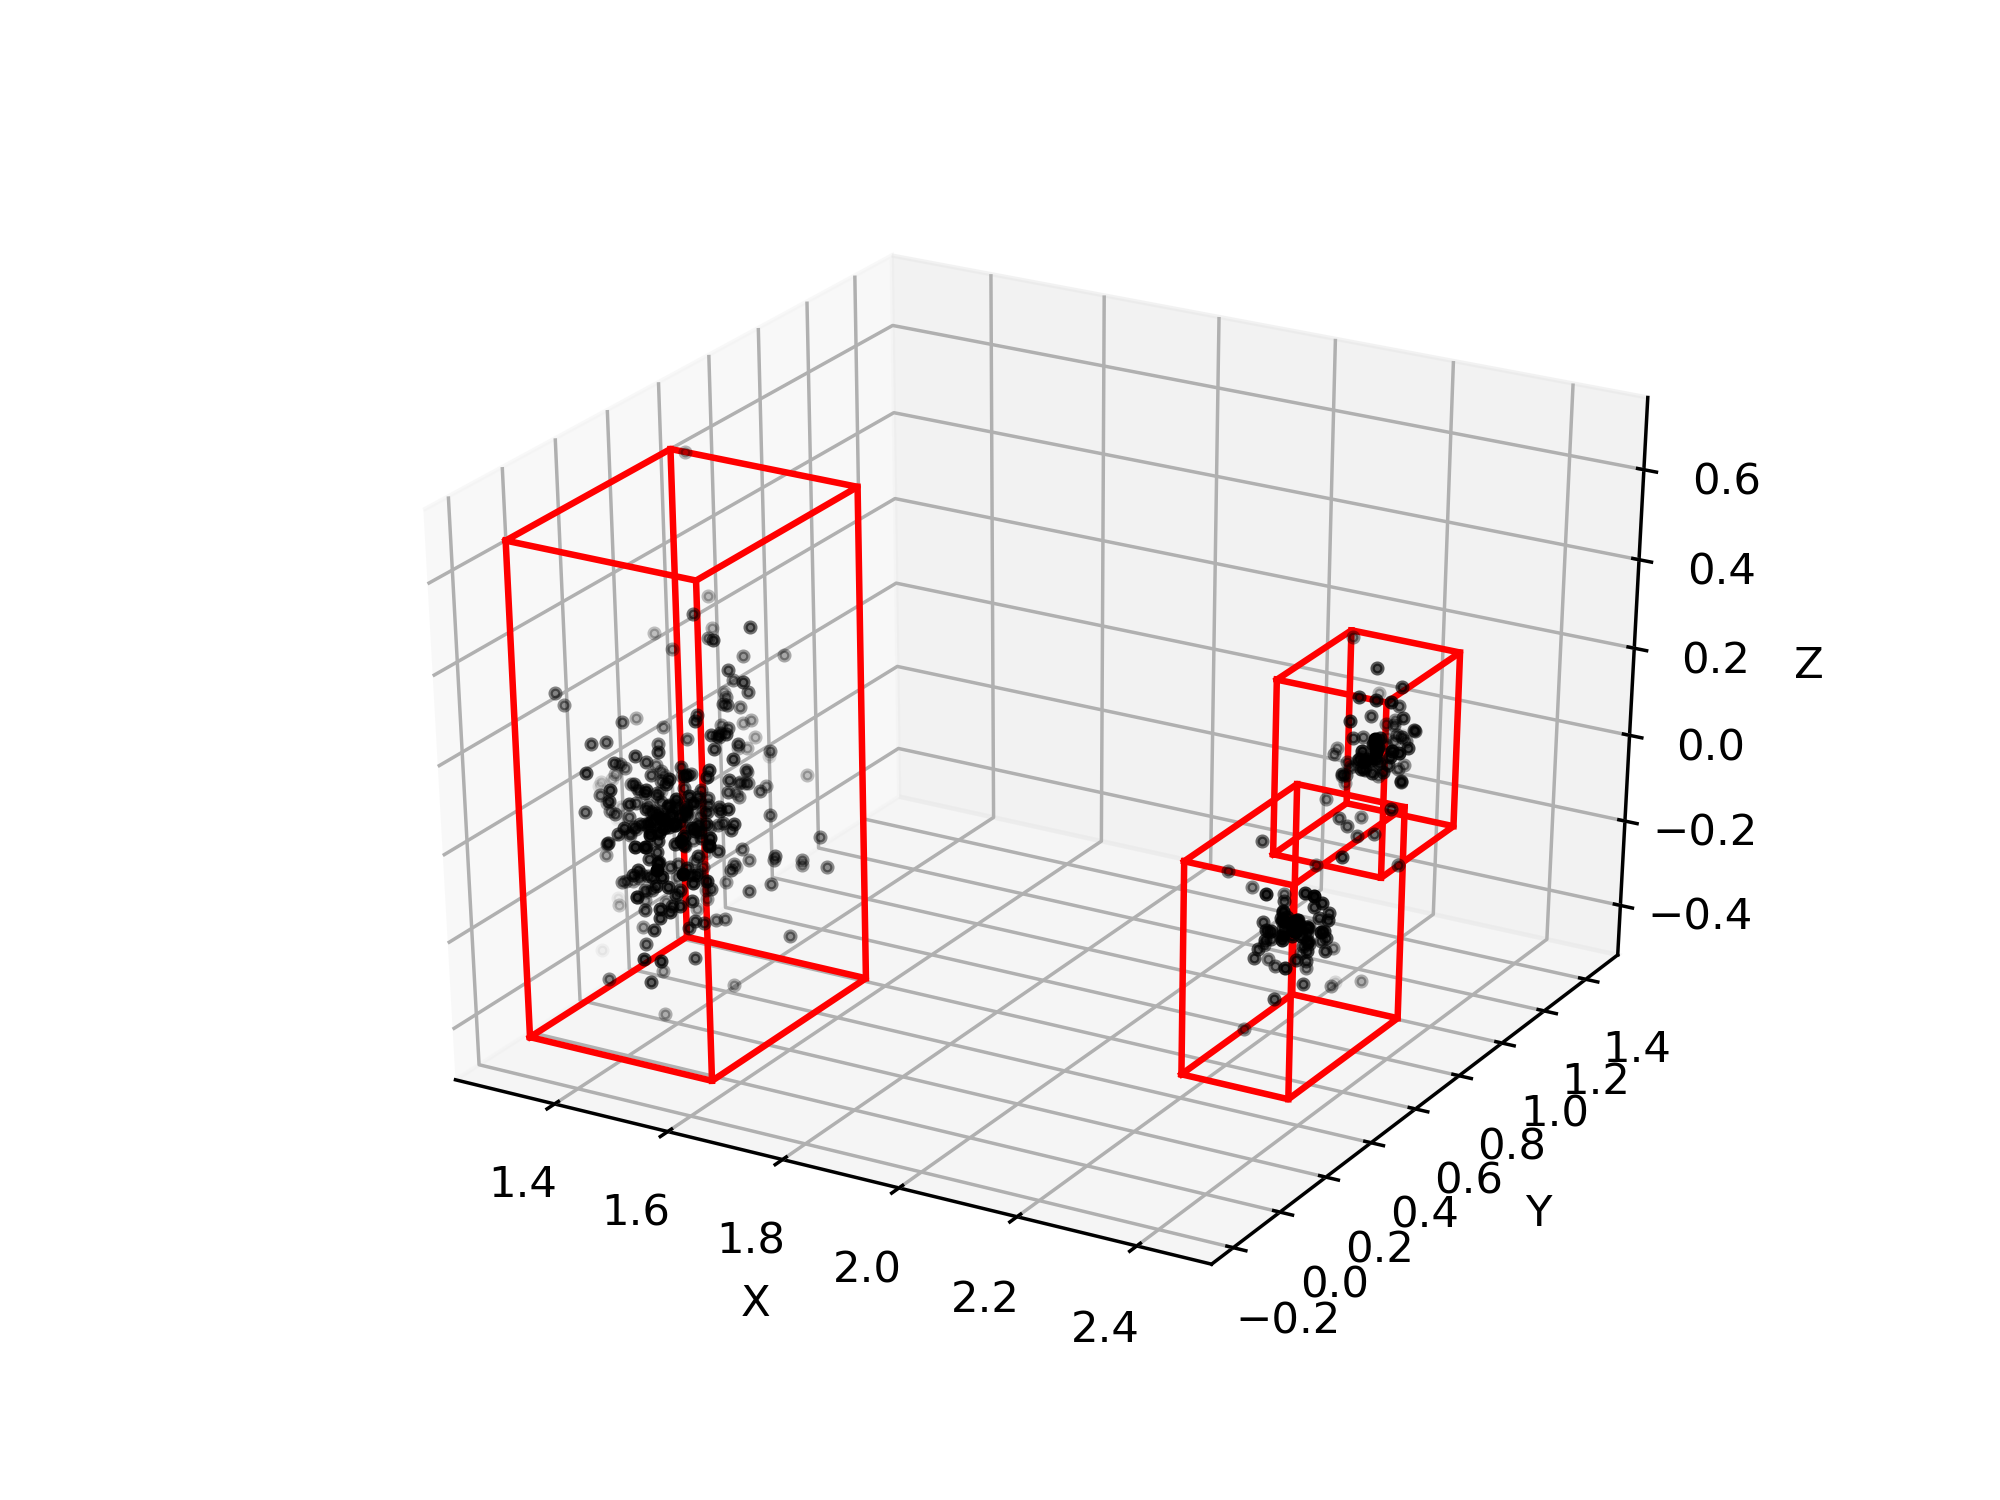

[2.08427734375, 2.2712890625, 1.10087890625, 1.43876953125, -0.2439453125, 0.1603515625, [2.1828510274960746, 1.2912380598917486, -0.04320282912165427]]
x=0.187	y=0.338	z=0.404
[2.2609579396802326, 2.4406454396802326, 0.24626408066860467, 0.7325922056686047, -0.3836641533430233, 0.10022256540697674, [2.3629199448436067, 0.4685904505122783, -0.10392500398912165]]
x=0.180	y=0.486	z=0.484
[1.3053644481689735, 1.6276300731689735, -0.17394706963667822, 0.4557404303633218, -0.43753784602076123, 0.6769152789792388, [1.4547426352352562, 0.11243765134741532, 0.010808542515896274]]
x=0.322	y=0.630	z=1.114


In [482]:
# i_list=list(np.linspace(0,1382,1383).astype(int))
i_list=list(np.linspace(1381,2753,1373).astype(int))
# i_list=list(np.linspace(2752,3919,1178).astype(int))

fig = plt.figure()
ax = fig.gca(projection = '3d')
ax_settings(ax)

# plot_data(ax,i_list,final)
# plot_data(ax,i_list_graph1[5],final,color="r")
# plot_data(ax,i_list_graph2[5],final,color="r")
# plot_data(ax,i_list_graph3_2[1],final,color="r")
plot_data(ax,i_list_graph1_check_func,final1)
verts = find_verts(i_list_graph1_check_func, final1)
plot_cube(ax, verts)
print(verts)
print("x=%.3f\ty=%.3f\tz=%.3f" %((verts[1]-verts[0]), (verts[3]-verts[2]), (verts[5]-verts[4])))
plot_data(ax,i_list_graph2_check_func,final2)
verts = find_verts(i_list_graph2_check_func, final2)
plot_cube(ax, verts)
print(verts)
print("x=%.3f\ty=%.3f\tz=%.3f" %((verts[1]-verts[0]), (verts[3]-verts[2]), (verts[5]-verts[4])))
plot_data(ax,i_list_graph3_check_func,final3)
verts = find_verts(i_list_graph3_check_func, final3)
plot_cube(ax, verts)
print(verts)
print("x=%.3f\ty=%.3f\tz=%.3f" %((verts[1]-verts[0]), (verts[3]-verts[2]), (verts[5]-verts[4])))
# plot_data(ax,i_list_graph3_check_func,final2,color="r")

# for cluster in figure_part:
#     if len(cluster)>2:
#         verts = find_verts(cluster, final2)
#         plot_cube(ax, verts)

# plot_traj(ax, int(frame_num_count/W))
# figure_size()

plt.show()
# fig.savefig("1.jpg", dpi = 300)

In [585]:
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
del colors['k']
del colors['w']

colors_by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name) for name, color in colors.items())
colors_names = []
for each in colors_by_hsv:
    if each[0][1]>=0.2:
        colors_names.append(each[1])

<IPython.core.display.Javascript object>


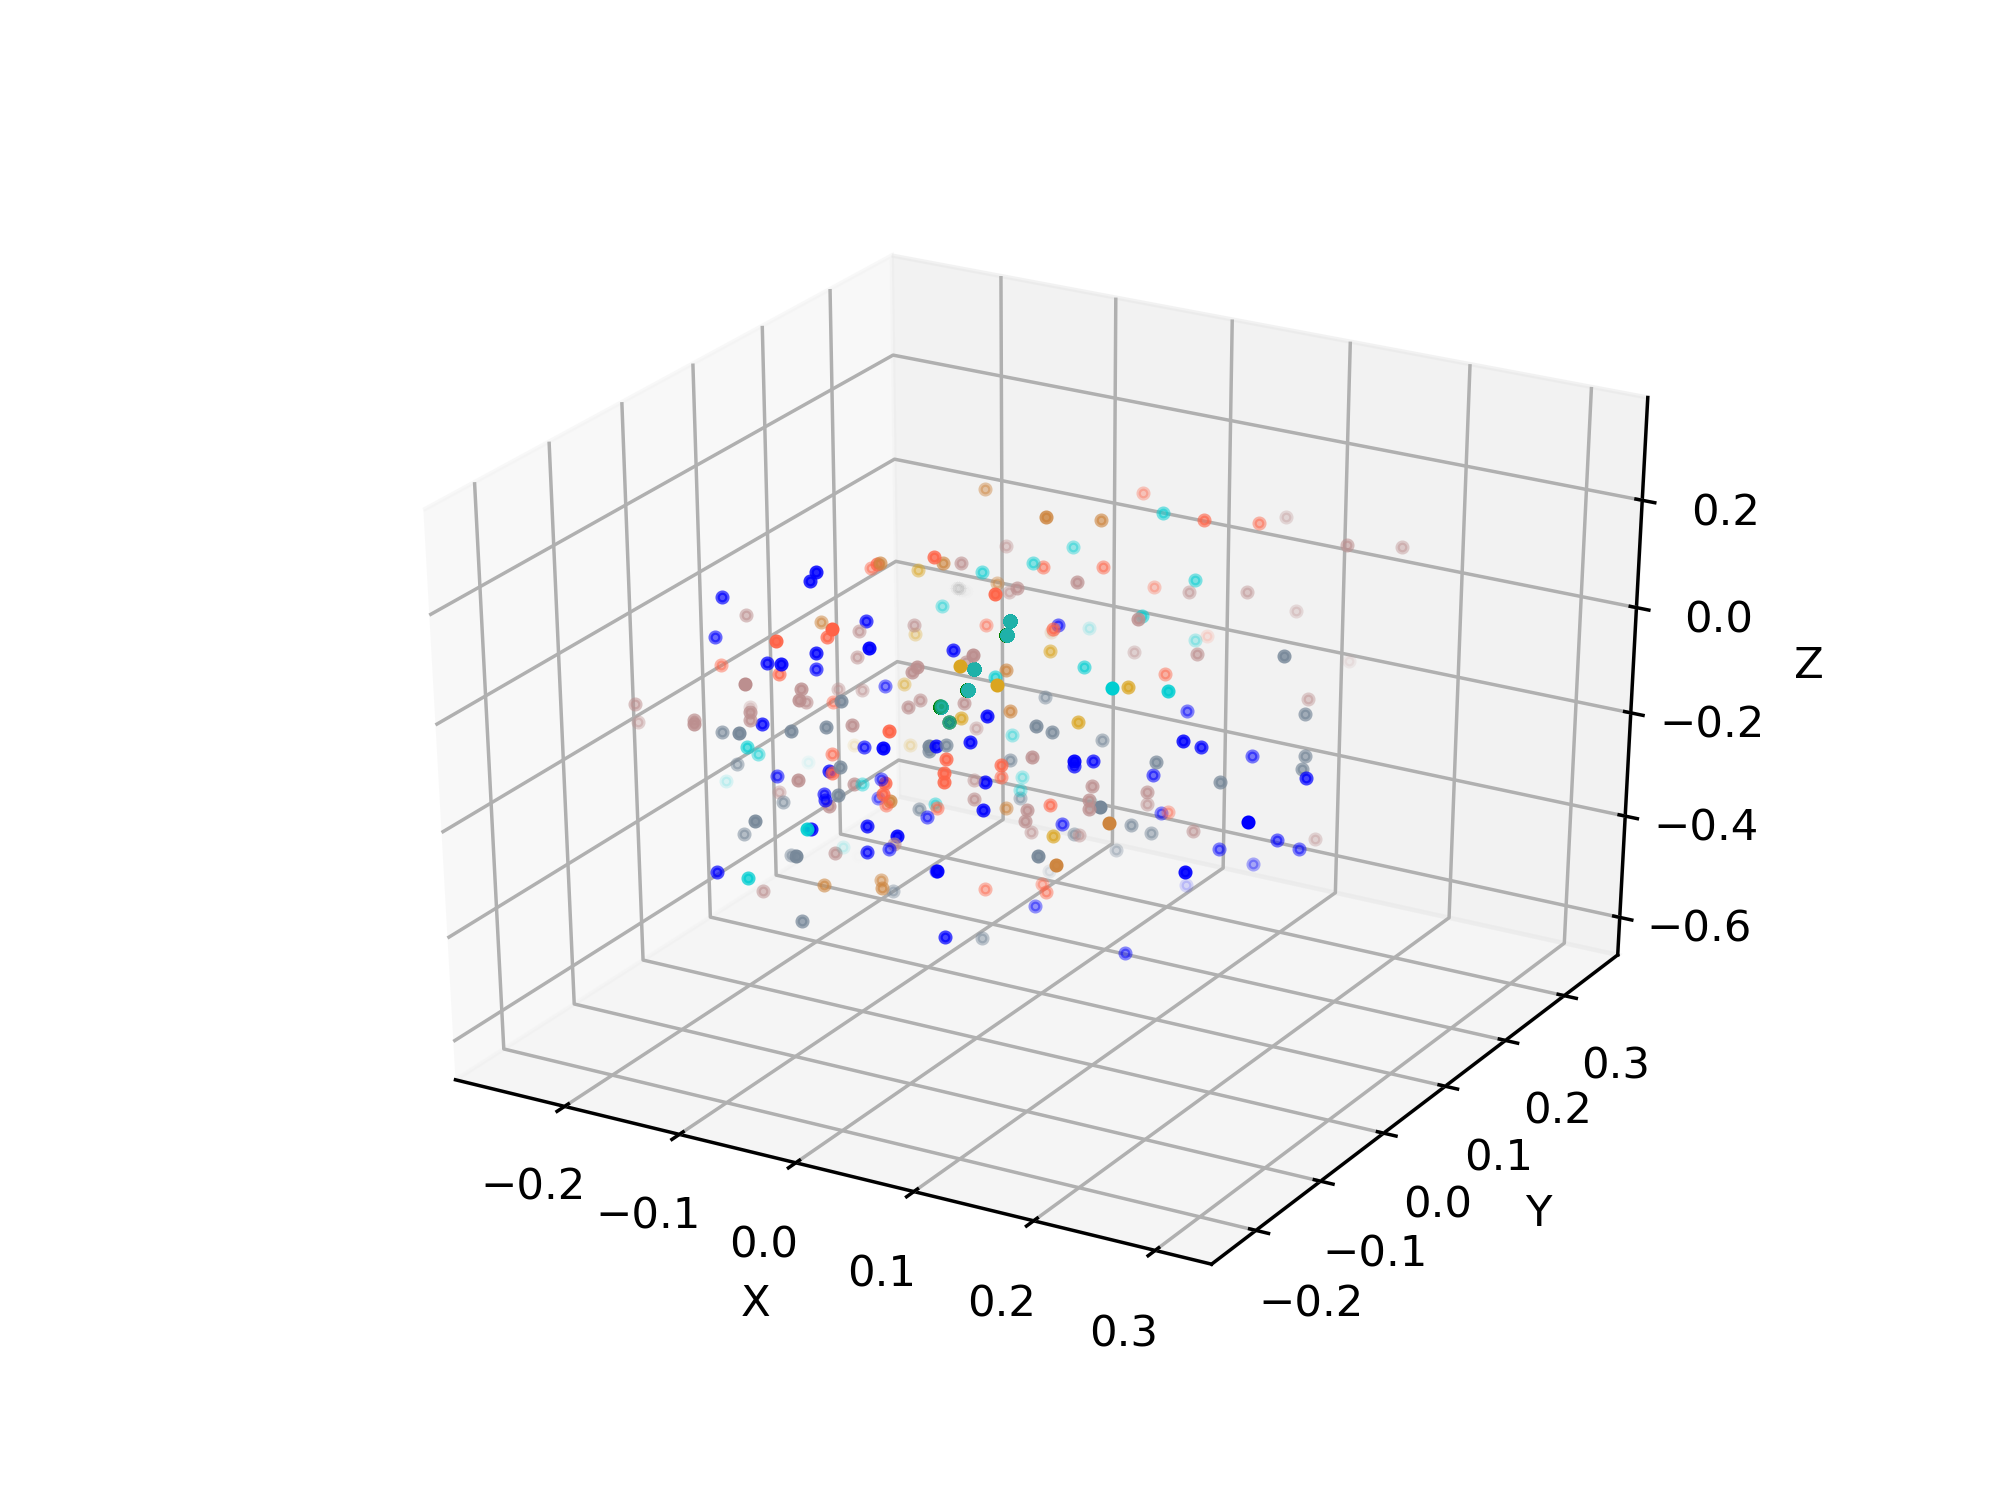

G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


[None, None, None, None]

In [600]:
# fig = plt.figure()
# ax = fig.gca(projection = '3d')
# ax_settings(ax)

i_list_all = dict()
for i in range(5):
    i_list = sort_data_graph(i*10, i*10+30, final)
    i_list = i_list_all[i*10]
    final2 = shift_data3(i_list, "center_xyorigin")
    # plot_data(ax, i_list, final, color = list(colors.keys())[i])
    plot_data(ax, i_list, final2, color = colors_names[i*10])
    del i_list
    del final2
    winsound.Beep(440,200)

plt.show()
[winsound.Beep(440,200) for _ in range(4)]

In [754]:
# Compute i_list from all 5358 data from "sample_walk_1.txt" and save to "i_list_sample_walk_1.npy"

i_list_all_30frame = dict()
for i in range(int(np.floor((frame_num_count-20)/10))):
    i_list = sort_data_graph(i*10, i*10+30, final)
    i_list_all_30frame[i*10] = i_list

    np.save("i_list_train_jump122_30frame.npy", i_list_all_30frame)
    del i_list

print("==================jump122s 30-frame done! =====================")

# i_list_all_60frame = dict()
# for i in range(int(np.floor((frame_num_count-50)/10))):
#     i_list = sort_data_graph(i*10, i*10+60, final)
#     i_list_all_60frame[i*10] = i_list

#     np.save("i_list_sample_walk_1_60frame.npy", i_list_all_60frame)
#     del i_list

# print("==================60-frame done!==================")

# Retrieve saved i_list:
# np.load("i_list_sample_walk_1.npy", allow_pickle = "TRUE").item()

time=0.0s	startFrame=0	endFrame=30	i_prev=0	i_curr=427
time=0.3333333333333333s	startFrame=10	endFrame=40	i_prev=147	i_curr=579
time=0.6666666666666666s	startFrame=20	endFrame=50	i_prev=282	i_curr=731
time=1.0s	startFrame=30	endFrame=60	i_prev=426	i_curr=882
time=1.3333333333333333s	startFrame=40	endFrame=70	i_prev=578	i_curr=1039
time=1.6666666666666667s	startFrame=50	endFrame=80	i_prev=730	i_curr=1177
time=2.0s	startFrame=60	endFrame=90	i_prev=881	i_curr=1325
time=2.3333333333333335s	startFrame=70	endFrame=100	i_prev=1038	i_curr=1476
time=2.6666666666666665s	startFrame=80	endFrame=110	i_prev=1176	i_curr=1622
time=3.0s	startFrame=90	endFrame=120	i_prev=1324	i_curr=1758
time=3.3333333333333335s	startFrame=100	endFrame=130	i_prev=1475	i_curr=1907
time=3.6666666666666665s	startFrame=110	endFrame=140	i_prev=1621	i_curr=2048
time=4.0s	startFrame=120	endFrame=150	i_prev=1757	i_curr=2193
time=4.333333333333333s	startFrame=130	endFrame=160	i_prev=1906	i_curr=2343
time=4.666666666666667s	start

time=37.666666666666664s	startFrame=1130	endFrame=1160	i_prev=16932	i_curr=17397
time=38.0s	startFrame=1140	endFrame=1170	i_prev=17086	i_curr=17549
time=38.333333333333336s	startFrame=1150	endFrame=1180	i_prev=17239	i_curr=17709
time=38.666666666666664s	startFrame=1160	endFrame=1190	i_prev=17396	i_curr=17858
time=39.0s	startFrame=1170	endFrame=1200	i_prev=17548	i_curr=18010
time=39.333333333333336s	startFrame=1180	endFrame=1210	i_prev=17708	i_curr=18170
time=39.666666666666664s	startFrame=1190	endFrame=1220	i_prev=17857	i_curr=18331
time=40.0s	startFrame=1200	endFrame=1230	i_prev=18009	i_curr=18482
time=40.333333333333336s	startFrame=1210	endFrame=1240	i_prev=18169	i_curr=18638
time=40.666666666666664s	startFrame=1220	endFrame=1250	i_prev=18330	i_curr=18775
time=41.0s	startFrame=1230	endFrame=1260	i_prev=18481	i_curr=18924
time=41.333333333333336s	startFrame=1240	endFrame=1270	i_prev=18637	i_curr=19079
time=41.666666666666664s	startFrame=1250	endFrame=1280	i_prev=18774	i_curr=19235
tim

time=73.66666666666667s	startFrame=2210	endFrame=2240	i_prev=40133	i_curr=40847
time=74.0s	startFrame=2220	endFrame=2250	i_prev=40381	i_curr=41075
time=74.33333333333333s	startFrame=2230	endFrame=2260	i_prev=40611	i_curr=41311
time=74.66666666666667s	startFrame=2240	endFrame=2270	i_prev=40846	i_curr=41545
time=75.0s	startFrame=2250	endFrame=2280	i_prev=41074	i_curr=41779
time=75.33333333333333s	startFrame=2260	endFrame=2290	i_prev=41310	i_curr=42009
time=75.66666666666667s	startFrame=2270	endFrame=2300	i_prev=41544	i_curr=42236
time=76.0s	startFrame=2280	endFrame=2310	i_prev=41778	i_curr=42453
time=76.33333333333333s	startFrame=2290	endFrame=2320	i_prev=42008	i_curr=42669
time=76.66666666666667s	startFrame=2300	endFrame=2330	i_prev=42235	i_curr=42869
time=77.0s	startFrame=2310	endFrame=2340	i_prev=42452	i_curr=43087
time=77.33333333333333s	startFrame=2320	endFrame=2350	i_prev=42668	i_curr=43306
time=77.66666666666667s	startFrame=2330	endFrame=2360	i_prev=42868	i_curr=43481
time=78.0s	s

time=109.66666666666667s	startFrame=3290	endFrame=3320	i_prev=60871	i_curr=61354
time=110.0s	startFrame=3300	endFrame=3330	i_prev=61034	i_curr=61515
time=110.33333333333333s	startFrame=3310	endFrame=3340	i_prev=61198	i_curr=61674
time=110.66666666666667s	startFrame=3320	endFrame=3350	i_prev=61353	i_curr=61828
time=111.0s	startFrame=3330	endFrame=3360	i_prev=61514	i_curr=61982
time=111.33333333333333s	startFrame=3340	endFrame=3370	i_prev=61673	i_curr=62137
time=111.66666666666667s	startFrame=3350	endFrame=3380	i_prev=61827	i_curr=62281
time=112.0s	startFrame=3360	endFrame=3390	i_prev=61981	i_curr=62434
time=112.33333333333333s	startFrame=3370	endFrame=3400	i_prev=62136	i_curr=62601
time=112.66666666666667s	startFrame=3380	endFrame=3410	i_prev=62280	i_curr=62760
time=113.0s	startFrame=3390	endFrame=3420	i_prev=62433	i_curr=62920
time=113.33333333333333s	startFrame=3400	endFrame=3430	i_prev=62600	i_curr=63079
time=113.66666666666667s	startFrame=3410	endFrame=3440	i_prev=62759	i_curr=63229

In [615]:
# Figure estimation after shift to center_xyorigin using 10 30-frame sample
x_shift = []
y_shift = []
z_shift = []
for each in i_list_all.values():
    each = list(each)
    final2 = shift_data3(each, "center_xyorigin")
    for each_point in each:
        x_shift.append(final2[each_point][1])
        y_shift.append(final2[each_point][2])
        z_shift.append(final2[each_point][3])
print(np.min(x_shift))
print(np.max(x_shift))
print(np.min(y_shift))
print(np.max(y_shift))
print(np.min(z_shift))
print(np.max(z_shift))

-0.25551568158494664
0.30503119341505336
-0.22525101900907485
0.3510195708563748
-0.607421875
0.3203125


## Shift_data functions

In [539]:
def shift_data2(i_list, mode = "frame_center", frame_patch = 1):
    # mode = "frame_center": shift each frame_patch so that each frame_center == center of all frames
    # mode = "frame_origin": shift each frame_patch so that each frame_center == origin ([0, 0, 0])
    # mode = "center_origin": shift all frames together so that the center of all frames == origin ([0, 0, 0])
    # mode = "center_xyorigin": shift all frames together in the xy=plane so that the center of all frames == xy origin ([0, 0, Z])

    # frame_patch: the relevant point position in each frame_patch remains the same in shift
    
    center = expect(i_list,index=7)
    
    final2 = np.zeros([len(frame_num), 6])

    # data2: To store frame_index with same frame_number in a dict
    data2 = dict()
    for i in i_list:
        if int(frame_num[i]) in data2:
            data2[frame_num[i]].append(i)
        else:
            data2[frame_num[i]] = []
            data2[frame_num[i]].append(i)
    

    for each_frame in data2:
        frame_center = expect(data2[each_frame], index=7)
        for i in data2[each_frame]:
            final2[i, 0] = int(frame_num[i])
            final2[i, 1] = x[i] - frame_center[0] + center[0]
            final2[i, 2] = y[i] - frame_center[1] + center[1]
            final2[i, 3] = z[i] - frame_center[2] + center[2] 
            final2[i, 4] = velocity[i]
            final2[i, 5] = intensity[i]

    return final2

In [540]:
def shift_data3(i_list, mode = "frame_center"):
    # mode = "frame_center": shift each frame_patch so that each frame_center == center of all frames
    # mode = "frame_origin": shift each frame_patch so that each frame_center == origin ([0, 0, 0])
    # mode = "center_origin": shift all frames together so that the center of all frames == origin ([0, 0, 0])
    # mode = "center_xyorigin": shift all frames together in the xy=plane so that the center of all frames == xy origin ([0, 0, Z])

    center = expect(i_list,index = 5)
    
    final2 = np.zeros([len(frame_num), 6])

    # data2: To store frame_index with same frame_number in a dict
    data2 = dict()
    for i in i_list:
        if int(frame_num[i]) in data2:
            data2[frame_num[i]].append(i)
        else:
            data2[frame_num[i]] = []
            data2[frame_num[i]].append(i)

    for each_frame in data2:
        frame_center = expect(data2[each_frame], index = 5)
        for i in data2[each_frame]:
            final2[i, 0] = int(frame_num[i])
            if mode == "frame_center":
                final2[i, 1] = x[i] - frame_center[0] + center[0] 
                final2[i, 2] = y[i] - frame_center[1] + center[1] 
                final2[i, 3] = z[i] - frame_center[2] + center[2]
            elif mode == "frame_origin":
                final2[i, 1] = x[i] - frame_center[0]
                final2[i, 2] = y[i] - frame_center[1]
                final2[i, 3] = z[i] - frame_center[2]
            elif mode == "center_origin":
                final2[i, 1] = x[i] - center[0] 
                final2[i, 2] = y[i] - center[1] 
                final2[i, 3] = z[i] - center[2]
            elif mode == "center_xyorigin":
                final2[i, 1] = x[i] - center[0] 
                final2[i, 2] = y[i] - center[1] 
                final2[i, 3] = z[i]

            final2[i, 4] = velocity[i]
            final2[i, 5] = intensity[i]

    return final2

## For debug

In [ ]:
# For debug
start=120
end=180
i_list = sort_data2(start,end,False)
plot_data(ax, i_list, final)
i_list = sort_data2(start,end)
verts = find_verts(i_list, final)
plot_cube(ax, verts)
# final2 = shift_data(i_list)
plot_skeleton(ax, i_list, final2)

plt.show()

In [ ]:
# For debug
# Plot figure in multi-frame
for i in range(0,10):
    i_list = sort_data2(60*i, 60*i+60)
    final2 = shift_data(i_list)
    # plot_data(ax, i_list, final2)
    verts = find_verts(i_list, final2)
    plot_cube(ax, verts, 0.5)
#     plot_skeleton(ax, i_list, final2)

plt.show()

<IPython.core.display.Javascript object>


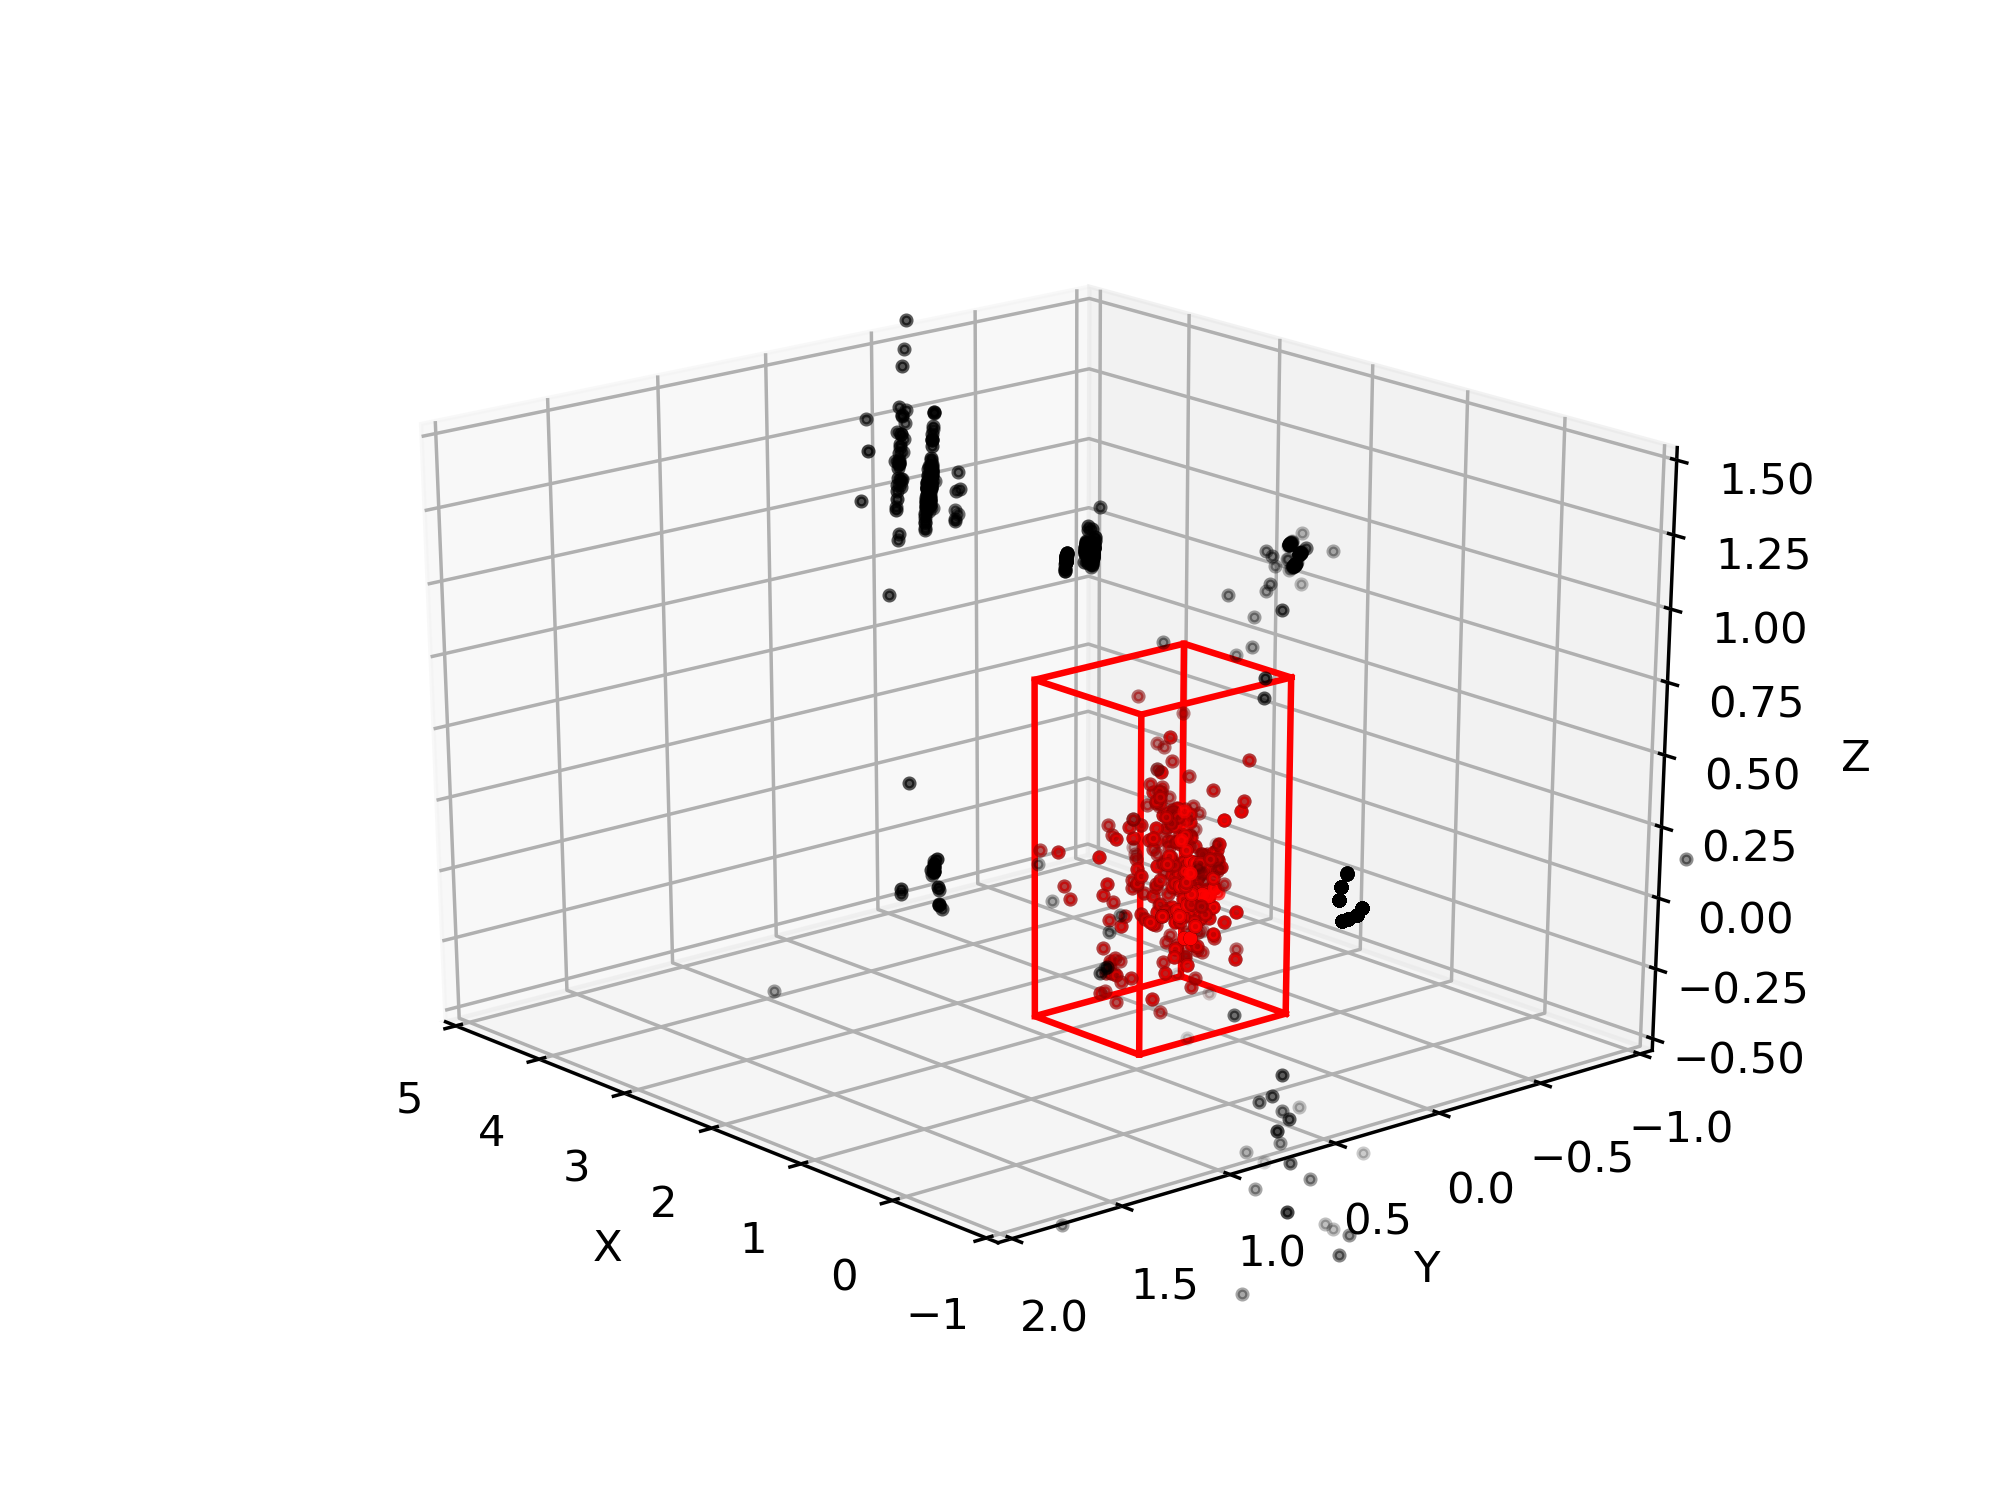

In [314]:
fig = plt.figure()
ax = fig.gca(projection = '3d')
ax_settings(ax)
# i_list=list(np.linspace(0,1382,1383).astype(int))
# i_list=list(np.linspace(1381,2753,1373).astype(int))
i_list=list(np.linspace(2752,3919,1178).astype(int))

# i_list = sort_data2(300,360)
# final2 = shift_data(i_list)
plot_data(ax, i_list, final)
plot_data(ax, i_list_graph3_2[1], final,color="r")
verts = find_verts(i_list_graph3_2[1], final)
plot_cube(ax, verts)

plt.show()

In [ ]:
fig = plt.figure()
ax = fig.gca(projection = '3d')
ax_settings(ax)
i_list = sort_data(0,60, False)
plot_data(ax, i_list, final)

plt.show()

In [28]:
# Test bounds
pillar = 32
i_prev = 0
i_curr = 1382
find_x_bounds(x[i_prev:i_curr], pillar, True)
find_y_bounds(y[i_prev:i_curr], pillar, True)
find_z_bounds(z[i_prev:i_curr], pillar, True)

plt.show()